# 正态性检验与比较

## 一、数据模拟

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
sns.set_theme()
from scipy.stats import skewnorm, shapiro, normaltest, anderson, cramervonmises, norm, chi2, kstest
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.stats.stattools import jarque_bera
from tabulate import tabulate

# 显著性水平
alpha = 0.05

# 随机数
a = 1  # 偏态参数
sample_size = 1000 # 样本量1000
np.random.seed(42)  # 随机种子
example_data = skewnorm.rvs(a, size=sample_size)
mean_skew, var_skew = skewnorm.mean(a), skewnorm.var(a)
example_data = (example_data - mean_skew) / np.sqrt(var_skew)
example_data

array([ 9.40517808e-01, -1.35680146e+00, -7.75630764e-02,  6.69800643e-02,
       -1.08077478e+00, -8.19802355e-01,  1.43582207e+00,  5.17901599e-01,
       -1.18012776e+00, -6.77058496e-01, -1.41470206e+00, -4.53697187e-01,
        1.30120604e+00,  1.54549814e+00, -6.92791789e-01, -3.71268784e-01,
        7.41979975e-01, -8.28615075e-01,  3.68681518e-01,  1.62938405e-01,
        1.01966443e+00,  1.36321584e-03, -6.46356551e-01, -1.29783869e+00,
       -1.69662494e+00, -2.14653979e-01,  2.69865608e-01, -2.58774572e-01,
       -6.94361891e-01,  4.42432866e-01,  5.24122631e-02, -5.26010682e-01,
       -1.01367865e+00, -3.31754641e-01, -3.92695185e-01, -9.85773797e-01,
       -1.55423640e+00,  2.24912069e+00,  2.61938611e-01,  3.82031670e-01,
        1.39127767e+00, -9.29568800e-01, -1.50810097e+00, -3.92477896e-01,
        7.30760894e-01, -8.23628282e-01, -8.47495577e-01, -1.12804967e+00,
        8.75505448e-01, -3.55363132e-01, -9.41526908e-01, -6.92513691e-01,
       -5.26697792e-01,  

## 二、图示法
### 2.1 直方图

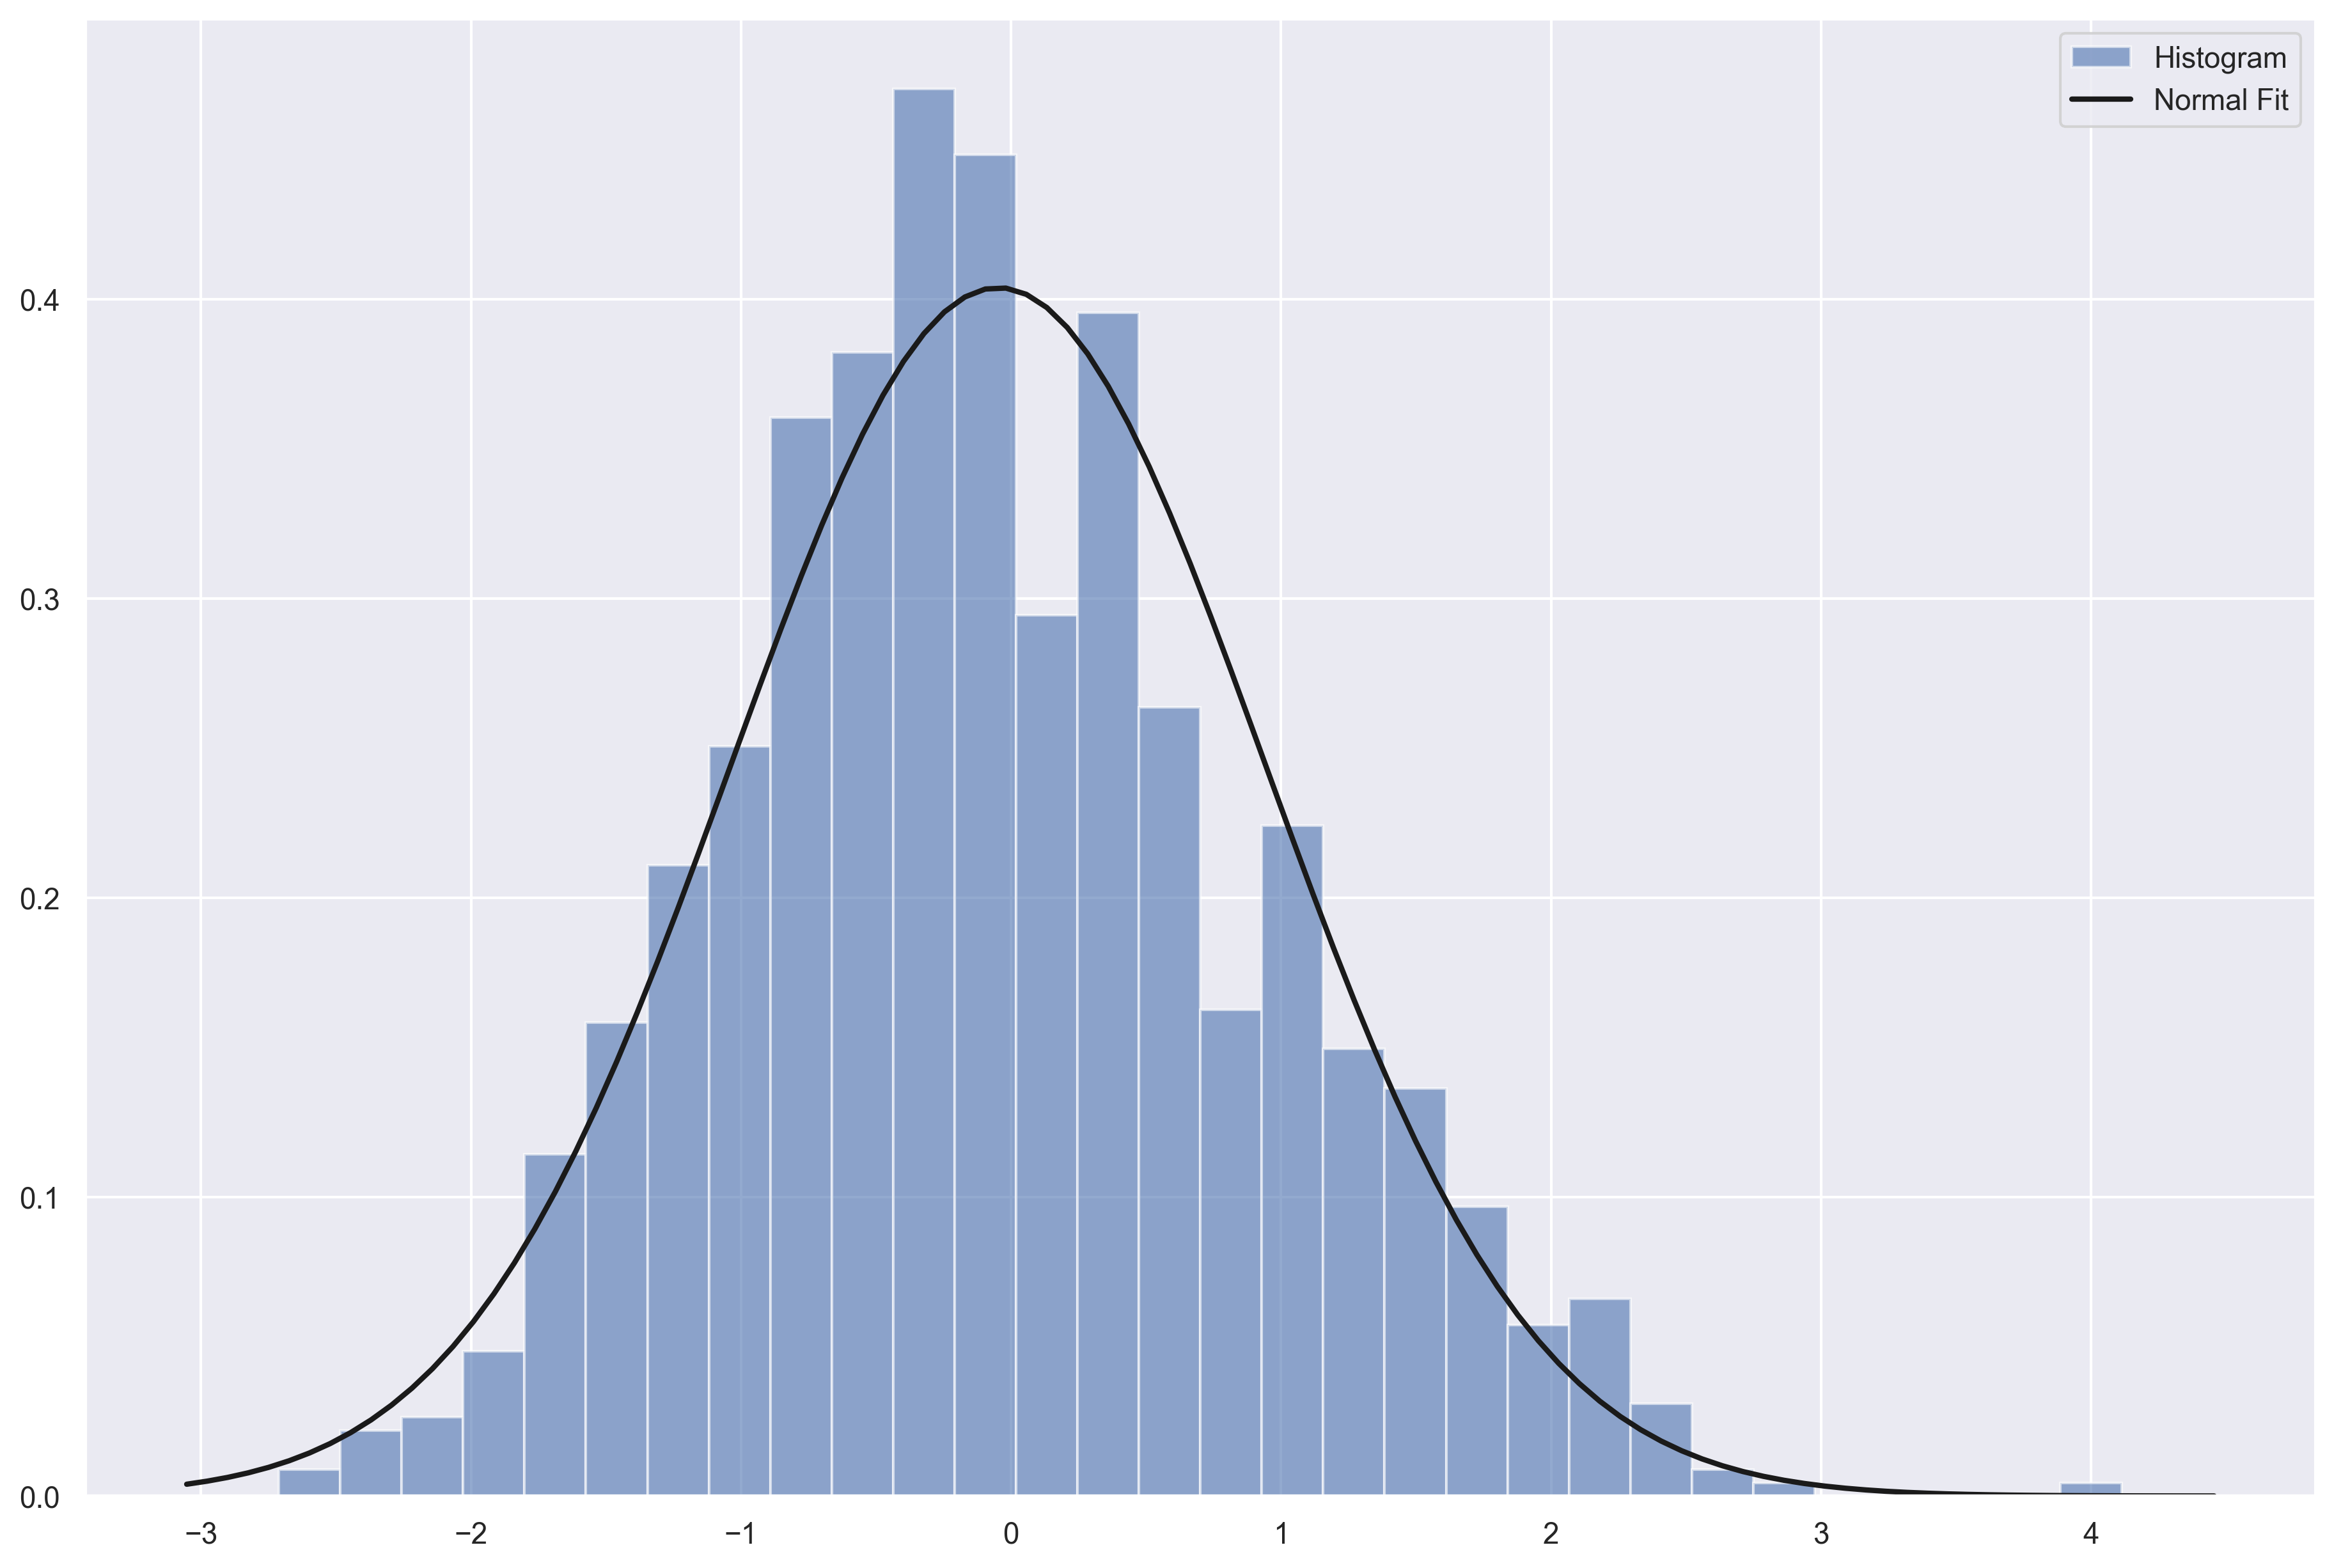

In [2]:
plt.figure(figsize=(15, 10), dpi=300)
plt.hist(example_data, bins=30, density=True, alpha=0.6, color='b', label='Histogram')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(example_data), np.std(example_data))
plt.plot(x, p, 'k', linewidth=2, label='Normal Fit')
plt.legend()
plt.show()

### 2.2 核密度图

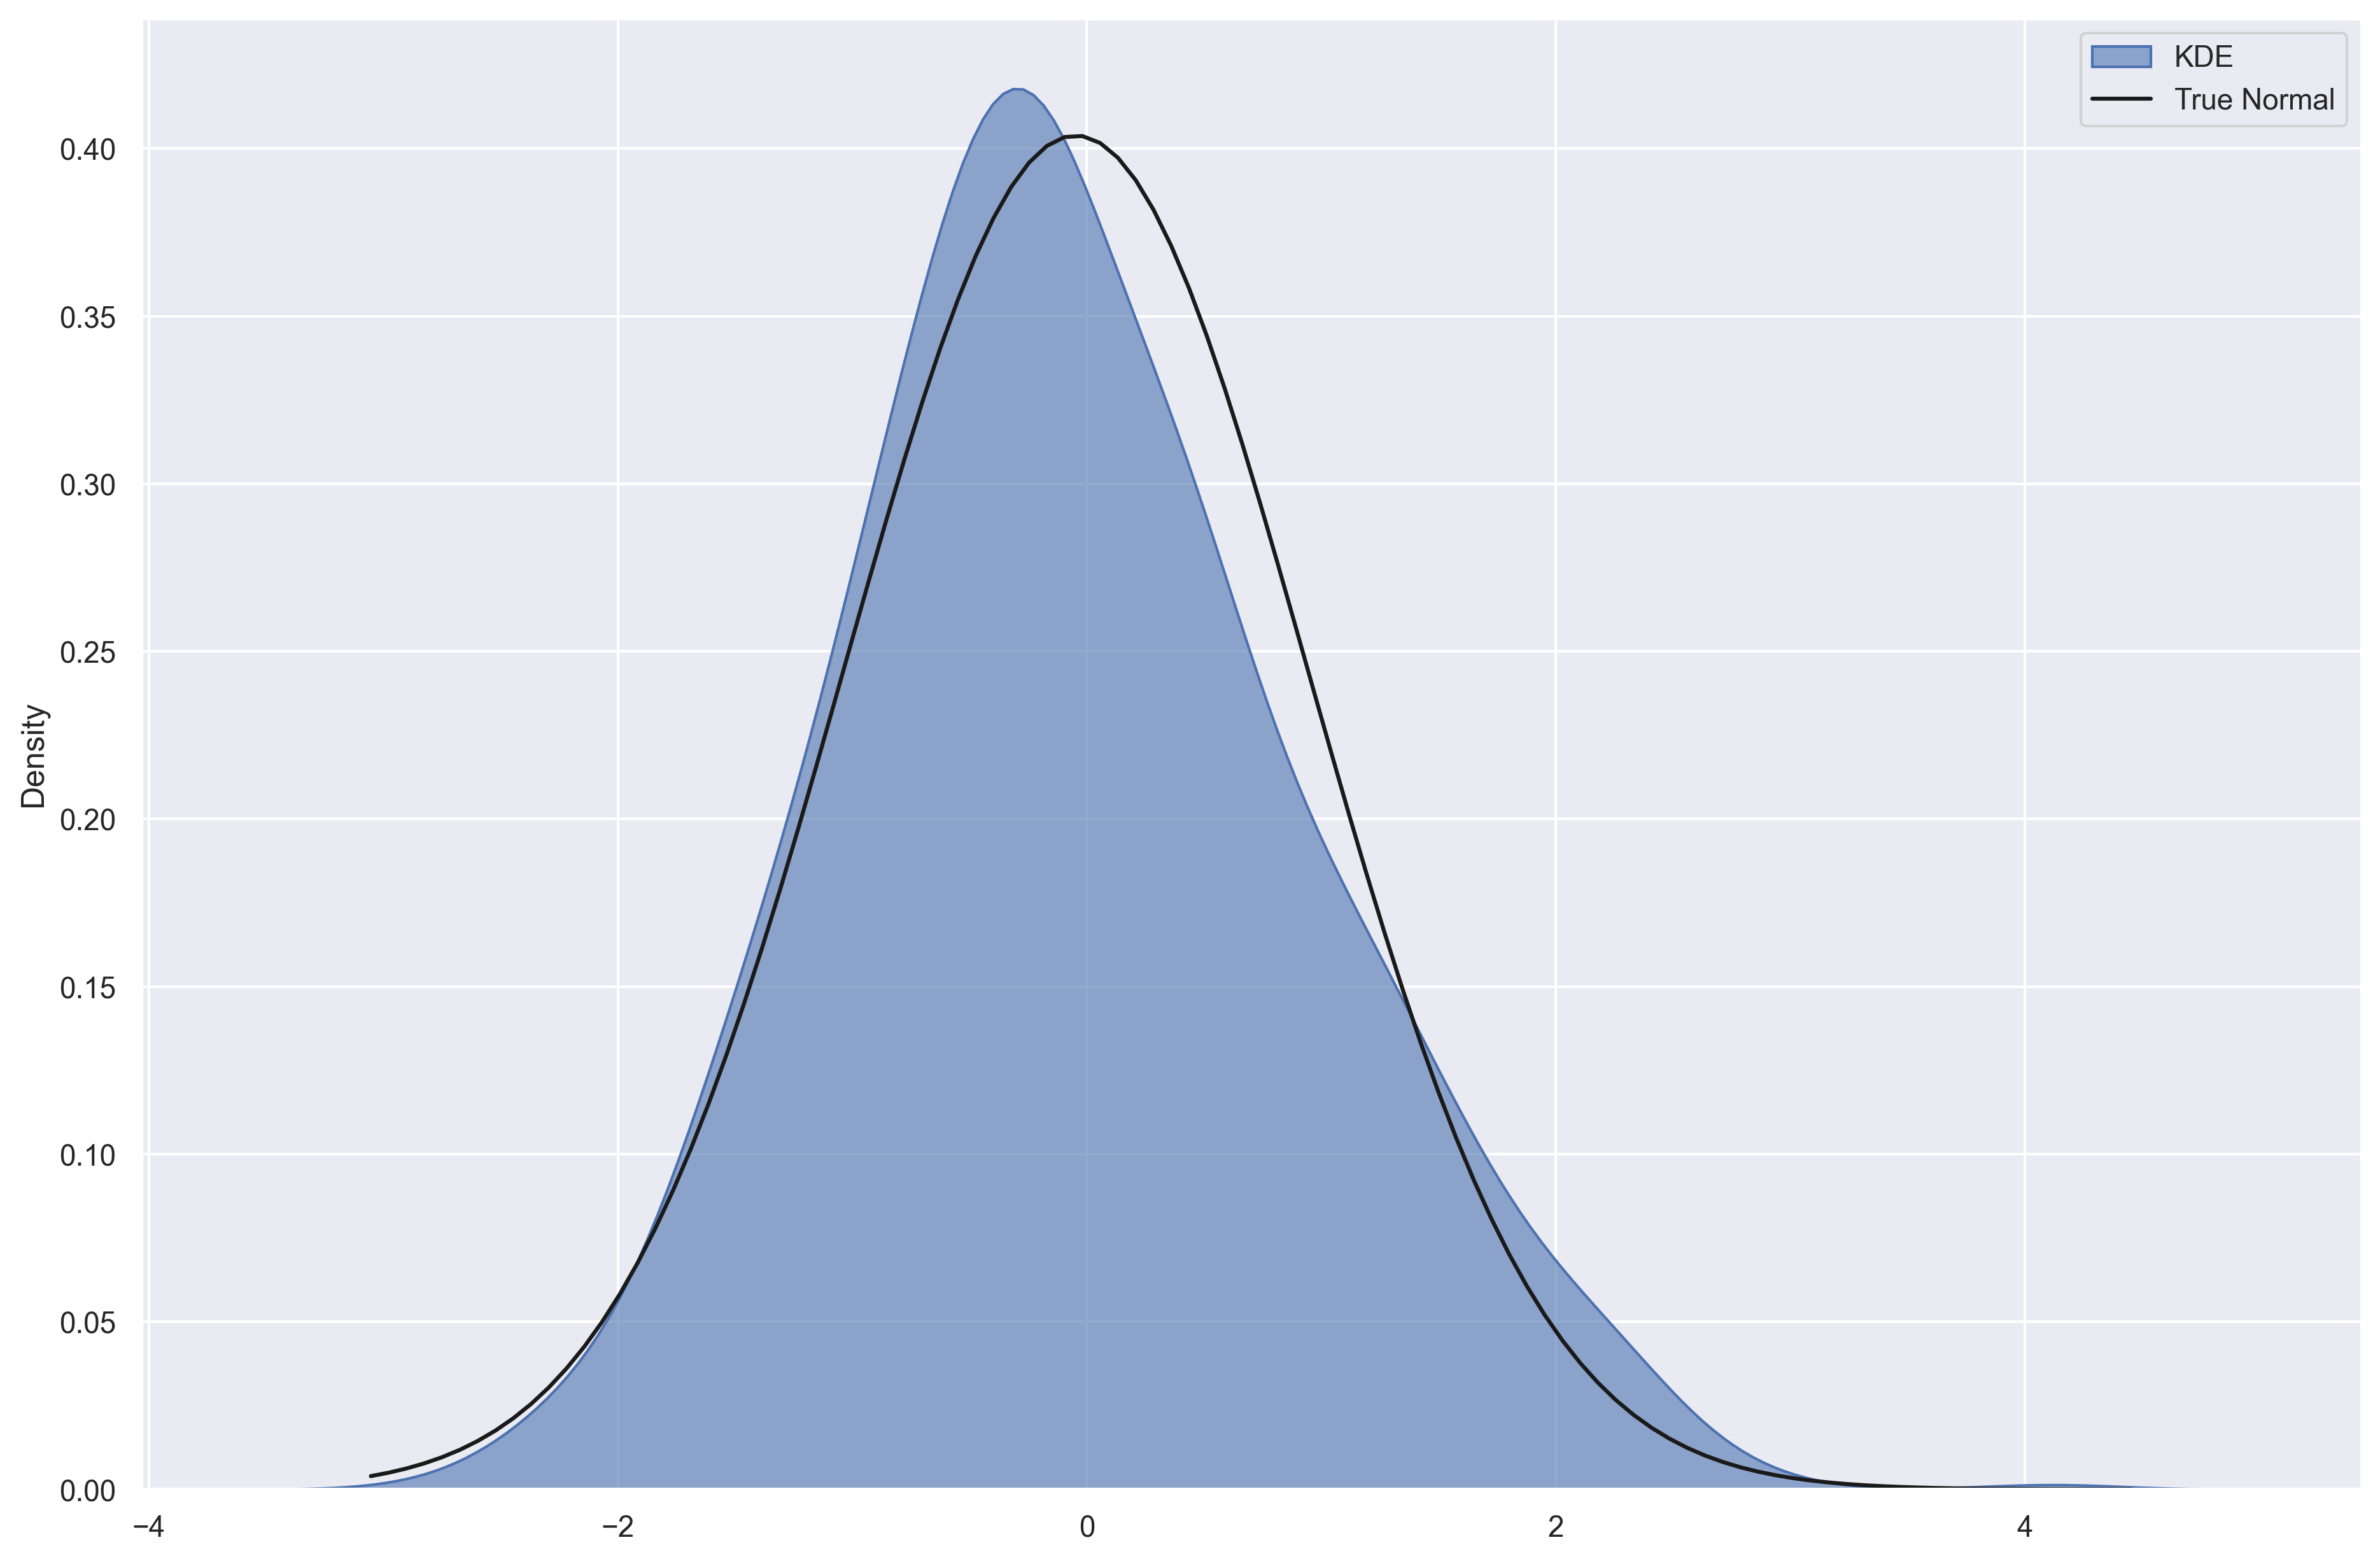

In [3]:
plt.figure(figsize=(15, 10), dpi=300)
sns.kdeplot(example_data, fill=True, color='b', alpha=0.6, bw_method=0.3, label='KDE')
plt.plot(x, p, 'k', label='True Normal')
plt.legend()
plt.show()

### 2.3 Q-Q图

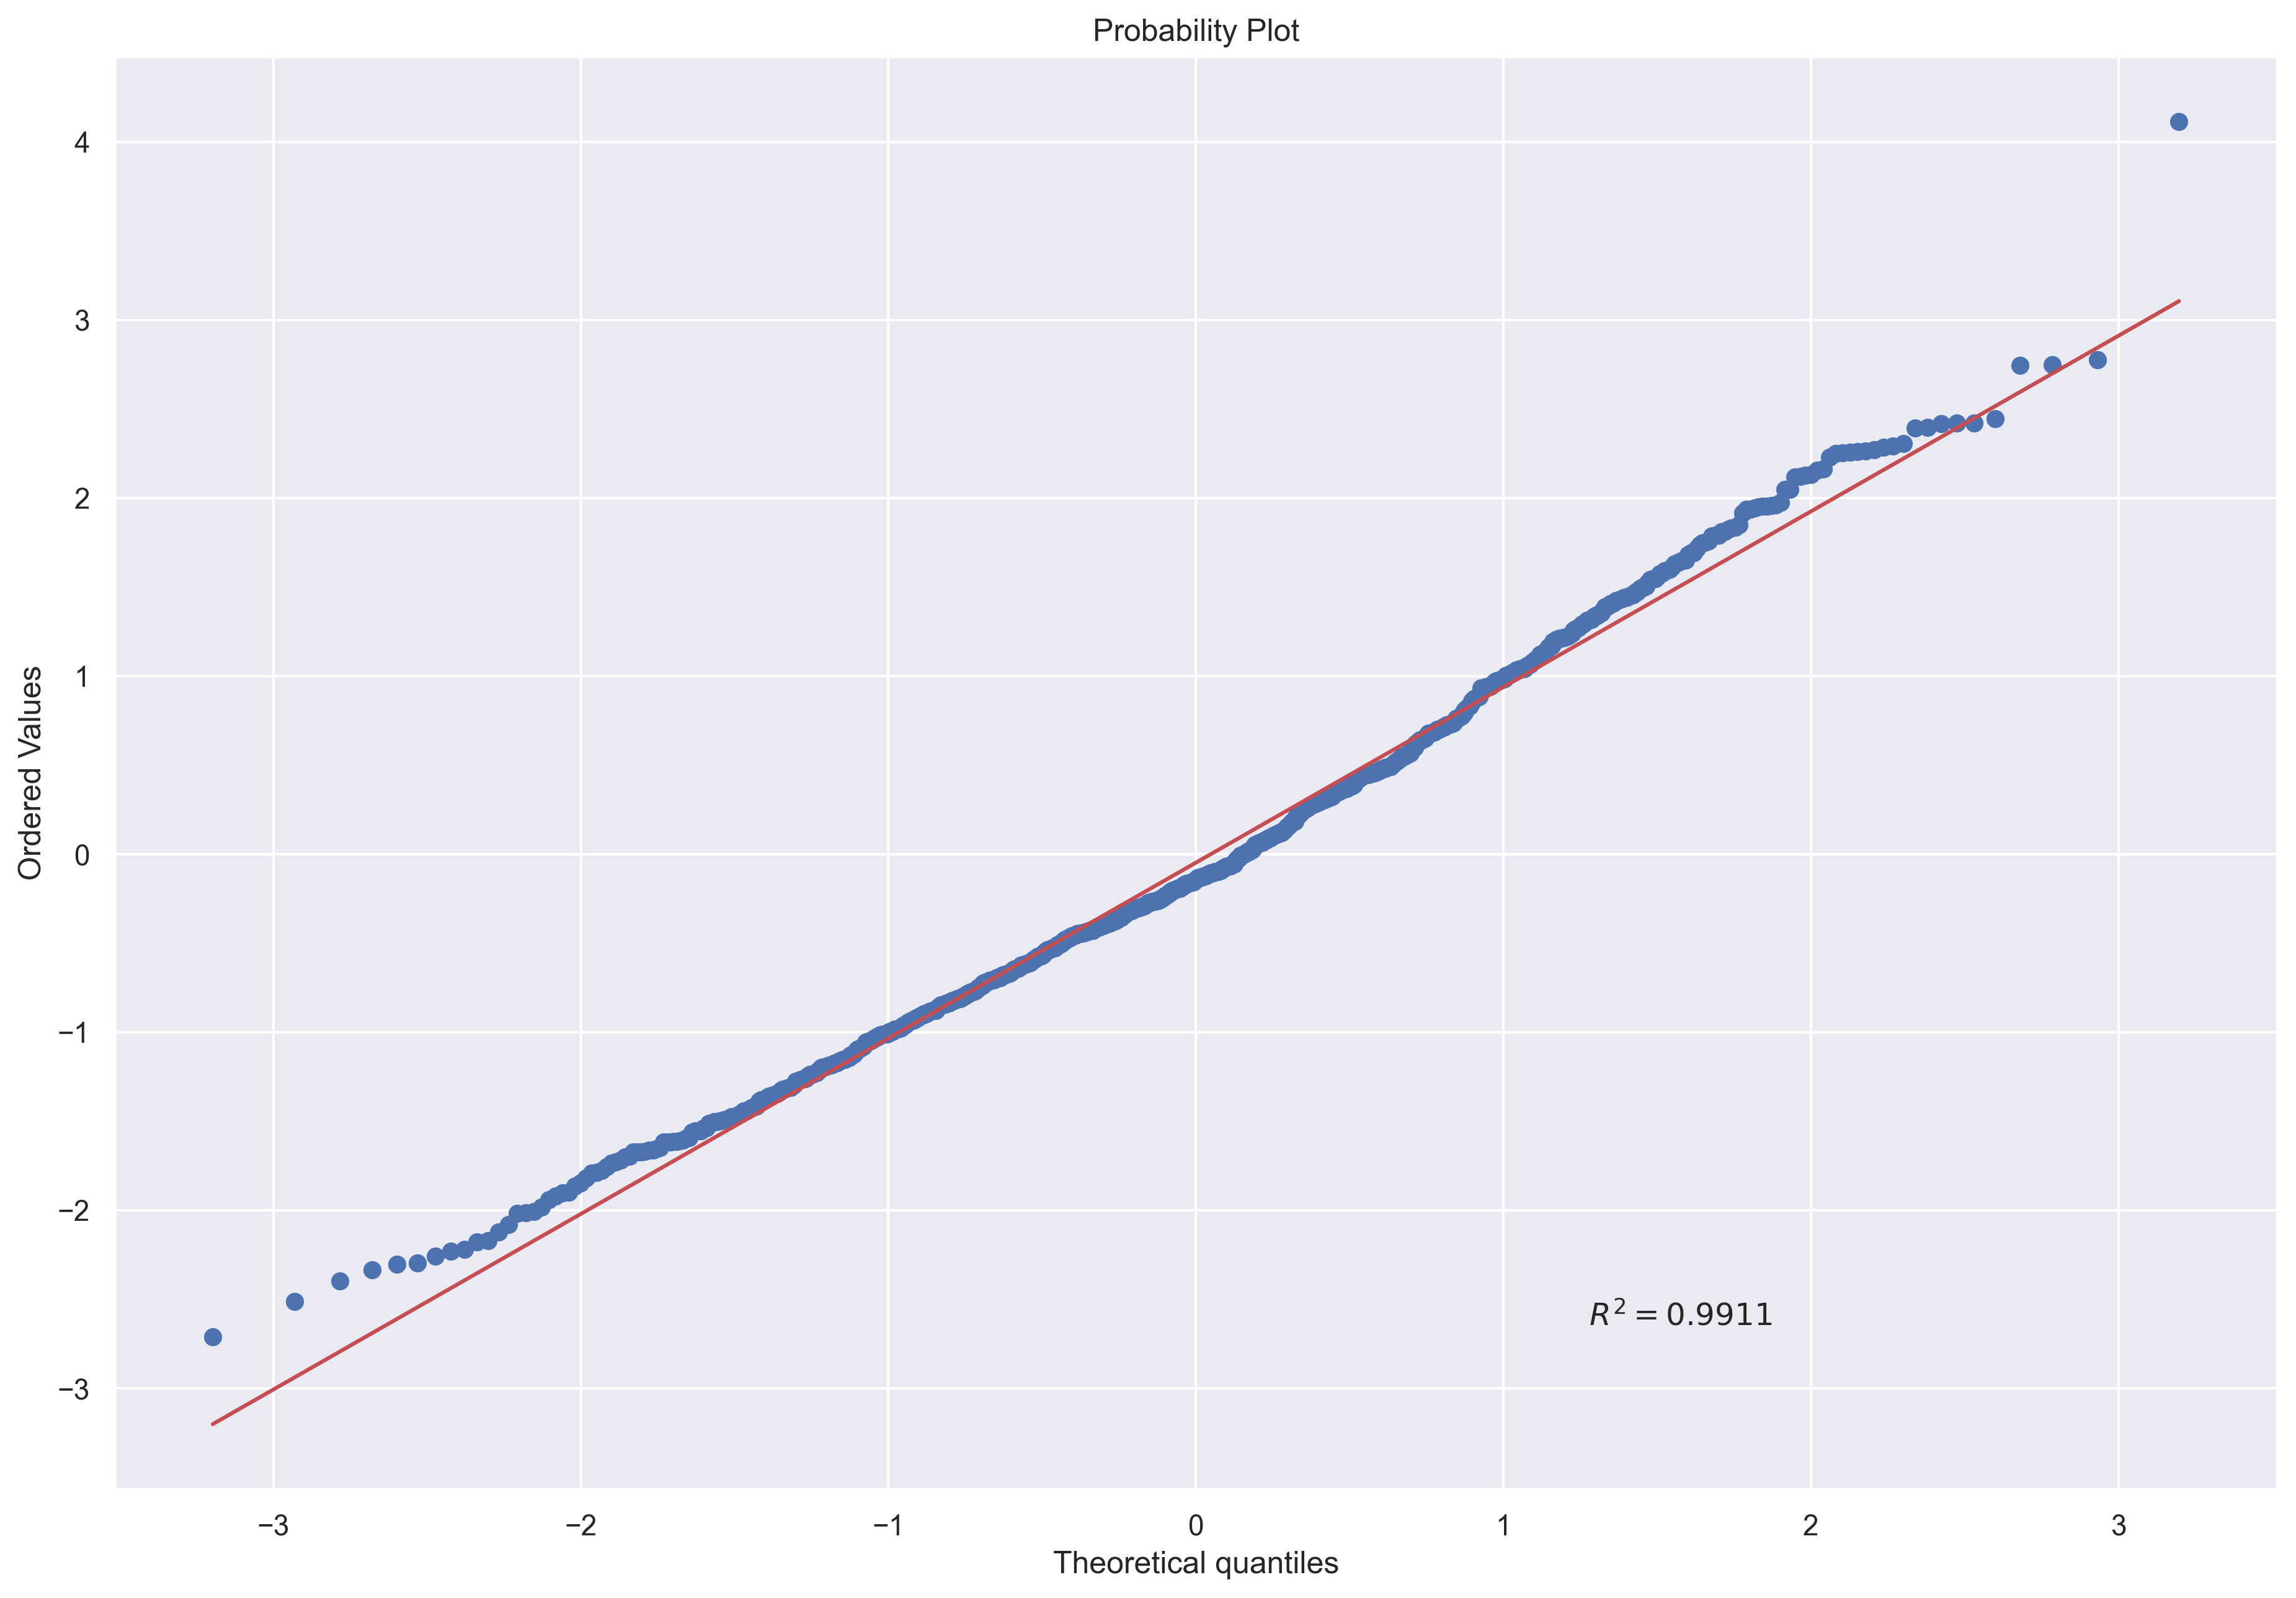

In [4]:
plt.figure(figsize=(15, 10), dpi=300)
stats.probplot(example_data, dist="norm", plot=plt, rvalue=True)
plt.show()

### 2.4 P-P图

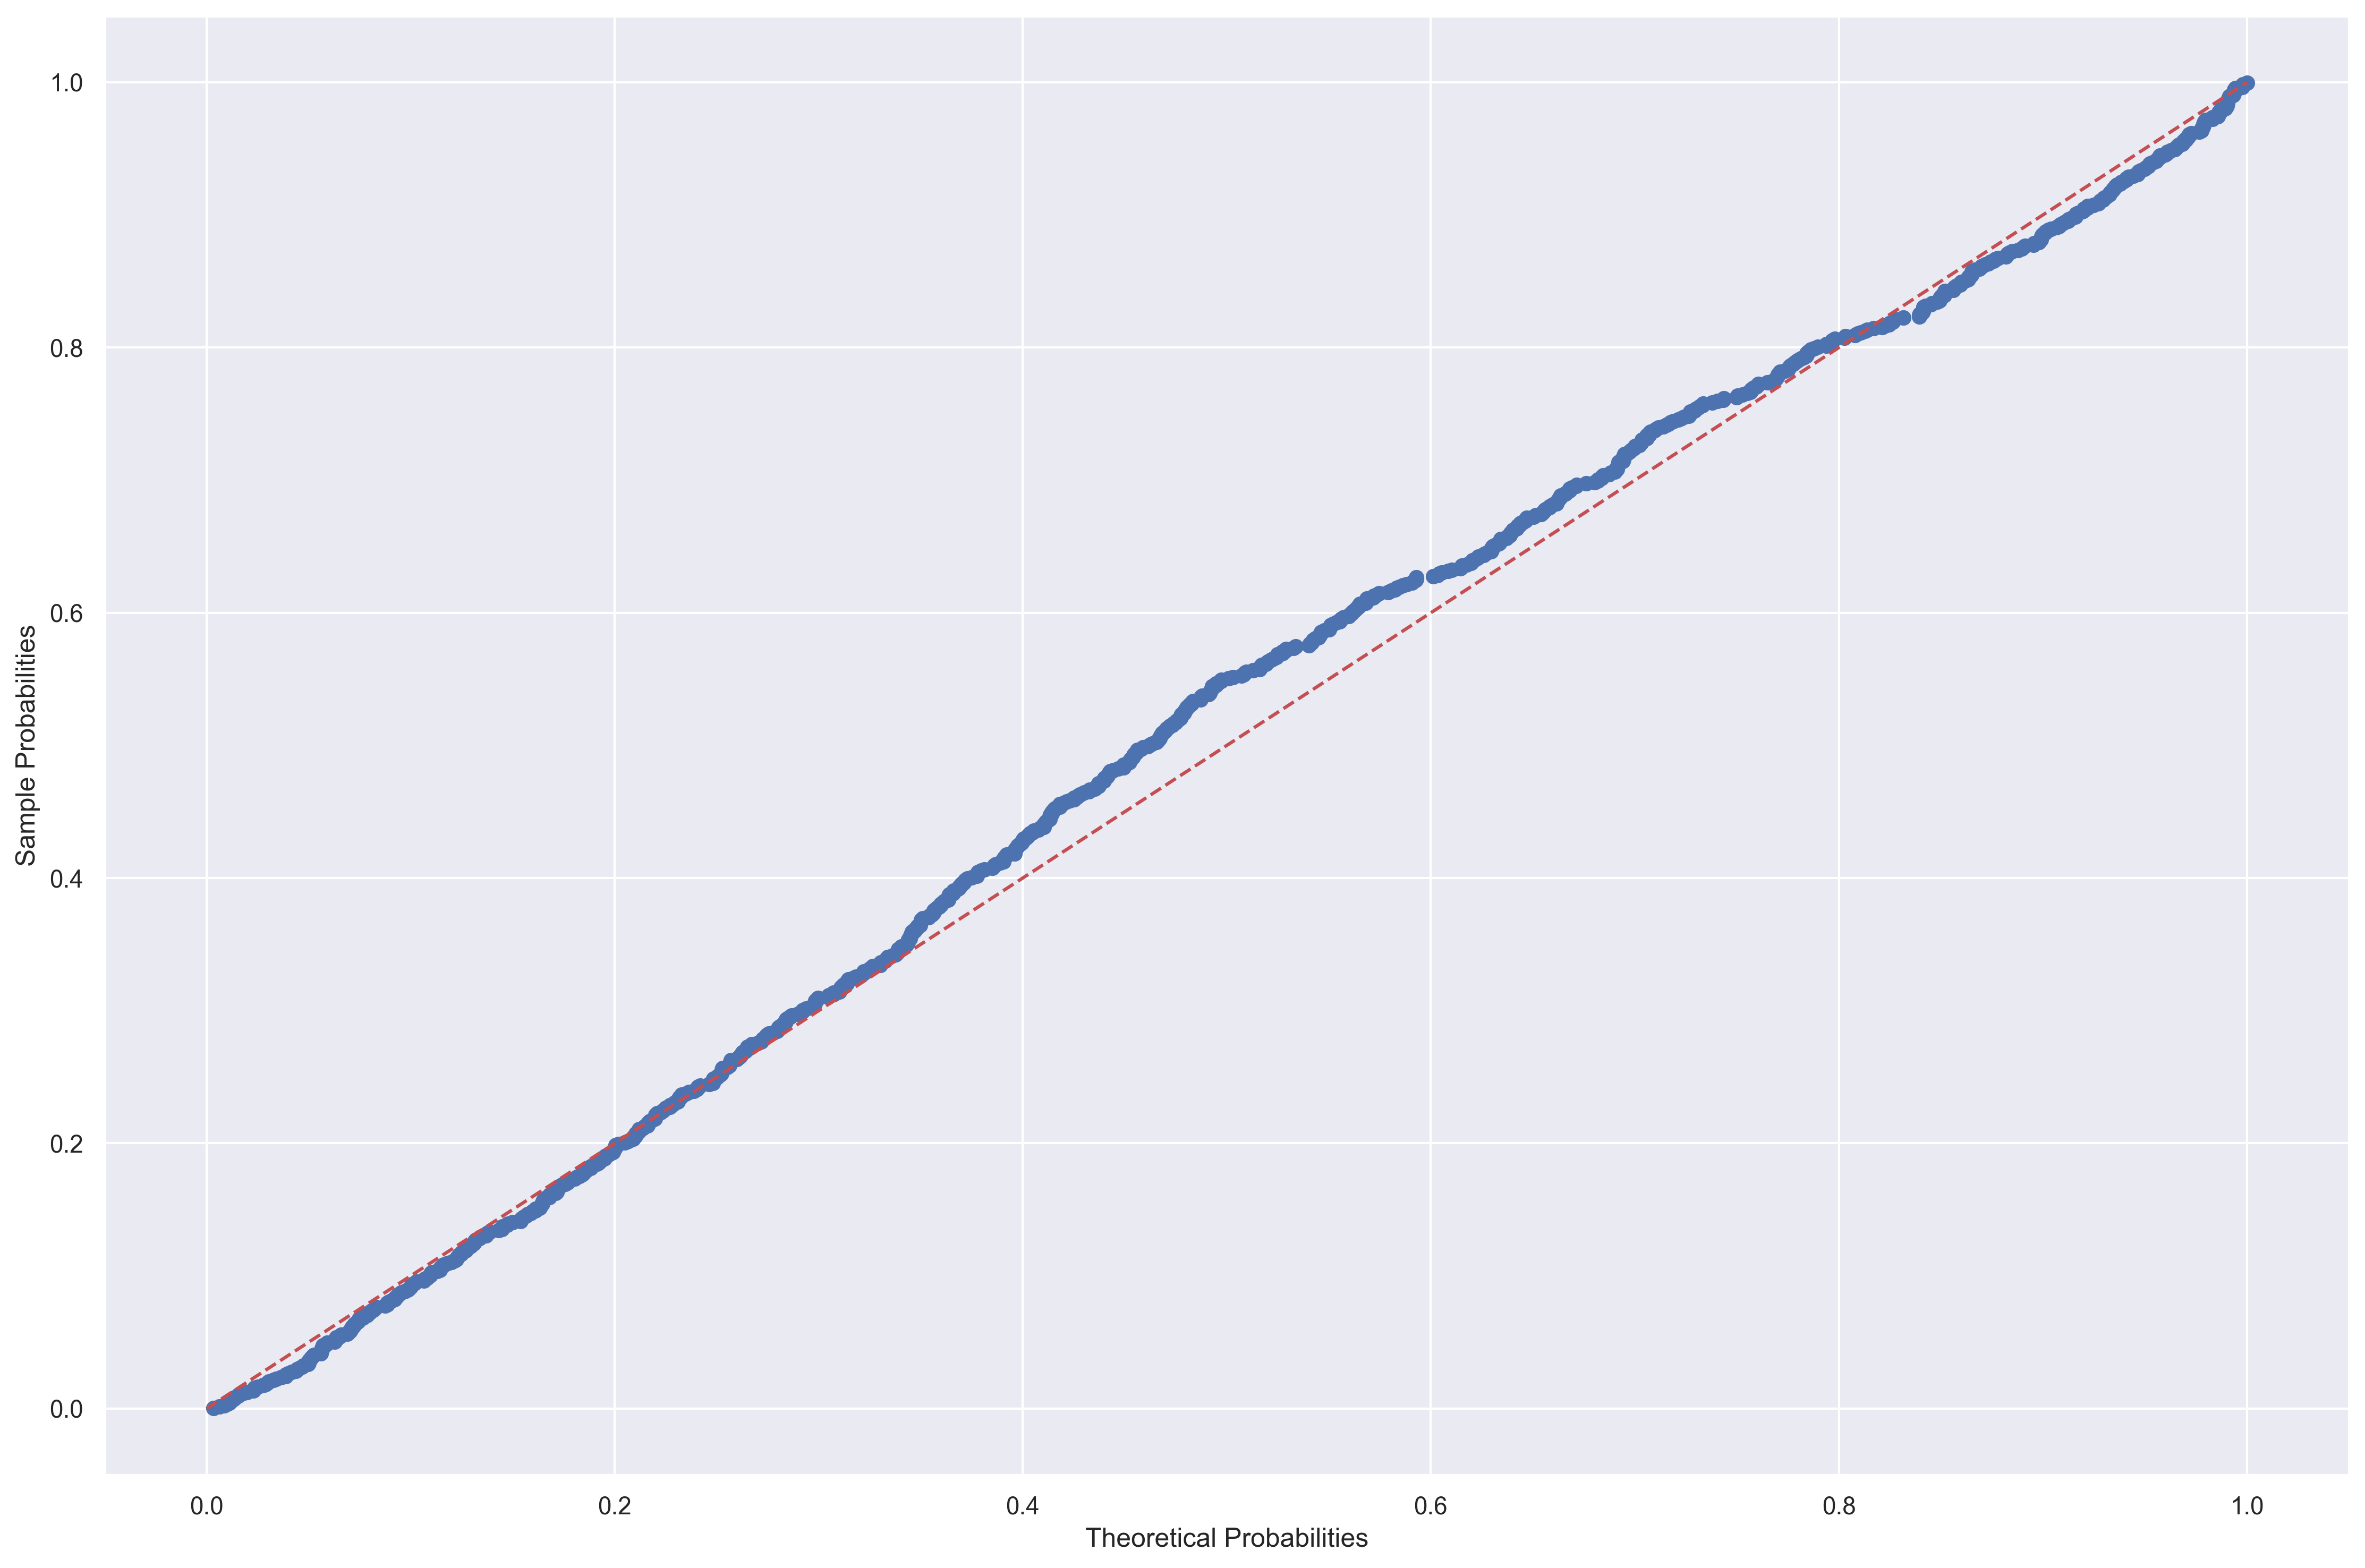

In [5]:
plt.figure(figsize=(15, 10), dpi=300)
sorted_data = np.sort(example_data)
n = len(sorted_data)
p_observed = (np.arange(n) + 0.5) / n  # 避免 0 和 1
p_expected = norm.cdf(sorted_data, loc=np.mean(example_data), scale=np.std(example_data))
plt.plot(p_expected, p_observed, 'bo')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Theoretical Probabilities')
plt.ylabel('Sample Probabilities')
plt.tight_layout()
plt.show()

## 三、假设检验法
### 3.1 偏峰检验法

In [6]:
# 1.偏峰检验法
def test_skew_kurtosis(data):
    """偏峰检验法"""
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    p_value = 1 - stats.norm.cdf(np.abs(skewness) + np.abs(kurtosis))
    if p_value < alpha:
        result = "拒绝原假设，数据不服从正态分布"
    else:
        result = "不能拒绝原假设，数据可能服从正态分布"
    return skewness, kurtosis, p_value, result
skewness, kurtosis, skew_kurtosis_p_value, skew_kurtosis_result = test_skew_kurtosis(example_data)
print(f"偏度: {skewness}")
print(f"峰度: {kurtosis}")
print(f"p值: {skew_kurtosis_p_value}")
print(f"检验结果: {skew_kurtosis_result}")

# 计算检验的power
num_simulations = 1000
rejections = 0
for _ in range(num_simulations):
    sim_data = skewnorm.rvs(a, size=sample_size)
    mean_skew, var_skew = skewnorm.mean(a), skewnorm.var(a)
    sim_data = (sim_data - mean_skew) / np.sqrt(var_skew)
    skewness, kurtosis, p_value, _ = test_skew_kurtosis(sim_data)
    if p_value < alpha:
        rejections += 1
skew_kurtosis_power = rejections / num_simulations
print(f"偏峰检验法的power: {skew_kurtosis_power}")

偏度: 0.34278824864742913
峰度: 0.059239117313244716
p值: 0.34383194320594845
检验结果: 不能拒绝原假设，数据可能服从正态分布
偏峰检验法的power: 0.0


### 3.2 Pearson卡方检验

In [7]:
# 2.Pearson卡方检验
def test_pearson_chi2(data, num_bins=10):
    """Pearson卡方检验"""
    mu, sigma = np.mean(data), np.std(data, ddof=1)
    quantiles = np.linspace(0, 1, num_bins + 1)
    bin_edges = norm.ppf(quantiles, loc=mu, scale=sigma)
    bin_edges[0], bin_edges[-1] = -np.inf, np.inf
    observed, _ = np.histogram(data, bins=bin_edges)
    expected = np.full(num_bins, len(data) / num_bins)
    chi2_stat = np.sum((observed - expected) ** 2 / expected)
    df = num_bins - 3  # 自由度：k - 1 - 2（估计参数）
    p_value = chi2.sf(chi2_stat, df)
    critical_value = chi2.ppf(1 - alpha, df)
    if p_value < alpha or chi2_stat > critical_value:
        result = "拒绝原假设，数据不服从正态分布"
    else:
        result = "不能拒绝原假设，数据可能服从正态分布"
    return chi2_stat, critical_value, p_value, result

chi2_stat, chi2_critical_value, chi2_p_value, chi2_result = test_pearson_chi2(example_data)
print(f"卡方统计量: {chi2_stat}")
print(f"临界值: {chi2_critical_value}")
print(f"p值: {chi2_p_value}")
print(f"检验结果: {chi2_result}")

# 计算检验的power
rejections = 0
for _ in range(num_simulations):
    sim_data = skewnorm.rvs(a, size=sample_size)
    mean_skew, var_skew = skewnorm.mean(a), skewnorm.var(a)
    sim_data = (sim_data - mean_skew) / np.sqrt(var_skew)
    chi2_stat, critical_value, p_value, _ = test_pearson_chi2(sim_data)
    if p_value < alpha or chi2_stat > critical_value:
        rejections += 1
chi2_power = rejections / num_simulations
print(f"检验的power: {chi2_power}")

卡方统计量: 26.38
临界值: 14.067140449340167
p值: 0.00043067697381099
检验结果: 拒绝原假设，数据不服从正态分布
检验的power: 0.071


### 3.3 Shapiro-Wilk检验

In [8]:
# 3. Shapiro-Wilk检验
def test_shapiro(data):
    """Shapiro-Wilk检验"""
    SW, p_value = shapiro(data)
    if p_value < alpha:
        result = "拒绝原假设，数据不服从正态分布"
    else:
        result = "不能拒绝原假设，数据可能服从正态分布"
    return SW, p_value, result
SW, SW_p_value, SW_result = test_shapiro(example_data)
print(f"Shapiro-Wilk统计量: {SW}")
print(f"p值: {SW_p_value}")
print(f"检验结果: {SW_result}")

# 计算检验的power
rejections = 0
for _ in range(num_simulations):
    sim_data = skewnorm.rvs(a, size=sample_size)
    mean_skew, var_skew = skewnorm.mean(a), skewnorm.var(a)
    sim_data = (sim_data - mean_skew) / np.sqrt(var_skew)
    W, p_value, _ = test_shapiro(sim_data)
    if p_value < alpha:
        rejections += 1
SW_power = rejections / num_simulations
print(f"Shapiro-Wilk检验的power: {SW_power}")

Shapiro-Wilk统计量: 0.9912144596561862
p值: 1.1174079032313598e-05
检验结果: 拒绝原假设，数据不服从正态分布
Shapiro-Wilk检验的power: 0.325


### 3.4 Shapiro-Francia检验

In [9]:
# 4. Shapiro-Francia检验
def test_shapiro_francia(data):
    """Shapiro-Francia检验"""
    SF, p_value = shapiro(data)
    if p_value < alpha:
        result = "拒绝原假设，数据不服从正态分布"
    else:
        result = "不能拒绝原假设，数据可能服从正态分布"
    return SF, p_value, result
SF, SF_p_value, SF_result = test_shapiro_francia(example_data)
print(f"Shapiro-Francia统计量: {SF}")
print(f"p值: {SF_p_value}")
print(f"检验结果: {SF_result}")

# 计算检验的power
rejections = 0
for _ in range(num_simulations):
    sim_data = skewnorm.rvs(a, size=sample_size)
    mean_skew, var_skew = skewnorm.mean(a), skewnorm.var(a)
    sim_data = (sim_data - mean_skew) / np.sqrt(var_skew)
    SF, p_value, _ = test_shapiro_francia(sim_data)
    if p_value < alpha:
        rejections += 1
SF_power = rejections / num_simulations
print(f"Shapiro-Francia检验的power: {SF_power}")

Shapiro-Francia统计量: 0.9912144596561862
p值: 1.1174079032313598e-05
检验结果: 拒绝原假设，数据不服从正态分布
Shapiro-Francia检验的power: 0.293


### 3.5 Kolmogorov-Smirnov检验

In [10]:
# 5. Kolmogorov-Smirnov检验
def test_ks(data):
    """Kolmogorov-Smirnov检验"""
    KS, p_value = kstest(data, 'norm')
    if p_value < alpha:
        result = "拒绝原假设，数据不服从正态分布"
    else:
        result = "不能拒绝原假设，数据可能服从正态分布"
    return KS, p_value, result
KS, KS_p_value, KS_result = test_ks(example_data)
print(f"KS统计量: {KS}")
print(f"p值: {KS_p_value}")
print(f"检验结果: {KS_result}")

# 计算检验的power
rejections = 0
for _ in range(num_simulations):
    sim_data = skewnorm.rvs(a, size=sample_size)
    mean_skew, var_skew = skewnorm.mean(a), skewnorm.var(a)
    sim_data = (sim_data - mean_skew) / np.sqrt(var_skew)
    D, p_value, _ = test_ks(sim_data)
    if p_value < alpha:
        rejections += 1
KS_power = rejections / num_simulations
print(f"KS检验的power: {KS_power}")

KS统计量: 0.07166421869159428
p值: 6.535427355734801e-05
检验结果: 拒绝原假设，数据不服从正态分布
KS检验的power: 0.085


### 3.6 Lilliefors检验

In [11]:
# 6. Lilliefors检验
def test_lilliefors(data):
    """Lilliefors检验"""
    L, p_value = lilliefors(data)
    if p_value < alpha:
        result = "拒绝原假设，数据不服从正态分布"
    else:
        result = "不能拒绝原假设，数据可能服从正态分布"
    return L, p_value, result
L, L_p_value, L_result = test_lilliefors(example_data)
print(f"Lilliefors统计量: {L}")
print(f"p值: {L_p_value}")
print(f"检验结果: {L_result}")

# 计算检验的power
rejections = 0
for _ in range(num_simulations):
    sim_data = skewnorm.rvs(a, size=sample_size)
    mean_skew, var_skew = skewnorm.mean(a), skewnorm.var(a)
    sim_data = (sim_data - mean_skew) / np.sqrt(var_skew)
    D, p_value, _ = test_lilliefors(sim_data)
    if p_value < alpha:
        rejections += 1
L_power = rejections / num_simulations
print(f"Lilliefors检验的power: {L_power}")

Lilliefors统计量: 0.05270168802440389
p值: 0.0009999999999998899
检验结果: 拒绝原假设，数据不服从正态分布
Lilliefors检验的power: 0.169


### 3.7 Cramer-von Mises检验

In [12]:
# 7. Cramer-von Mises检验
def test_cramer_von_mises(data):
    """Cramer-von Mises检验"""
    result = cramervonmises(data, 'norm')
    CVM = result.statistic
    p_value = result.pvalue
    if p_value < alpha:
        result = "拒绝原假设，数据不服从正态分布"
    else:
        result = "不能拒绝原假设，数据可能服从正态分布"
    return CVM, p_value, result
CVM, CVM_p_value, CVM_result = test_cramer_von_mises(example_data)
print(f"CVM统计量: {CVM}")
print(f"p值: {CVM_p_value}")
print(f"检验结果: {CVM_result}")

# 计算检验的power
rejections = 0
for _ in range(num_simulations):
    sim_data = skewnorm.rvs(a, size=sample_size)
    mean_skew, var_skew = skewnorm.mean(a), skewnorm.var(a)
    sim_data = (sim_data - mean_skew) / np.sqrt(var_skew)
    W, p_value, _ = test_cramer_von_mises(sim_data)
    if p_value < alpha:
        rejections += 1
CVM_power = rejections / num_simulations
print(f"Cramer-von Mises检验的power: {CVM_power}")

CVM统计量: 1.1075637981258413
p值: 0.0013746067573003895
检验结果: 拒绝原假设，数据不服从正态分布
Cramer-von Mises检验的power: 0.084


### 3.8 Anderson-Darling检验

In [13]:
# 8. Anderson-Darling检验
def test_anderson_darling(data):
    """Anderson-Darling检验"""
    AD, critical_values, significance_level = anderson(data, dist='norm')
    if AD > critical_values[2]:  # 5%显著性水平
        result = "拒绝原假设，数据不服从正态分布"
    else:
        result = "不能拒绝原假设，数据可能服从正态分布"
    return AD, critical_values, significance_level, result
AD, AD_critical_values, significance_level, AD_result = test_anderson_darling(example_data)
print(f"AD统计量: {AD}")
print(f"临界值: {AD_critical_values}")
print(f"显著性水平: {significance_level}")
print(f"检验结果: {AD_result}")

# 计算检验的power
rejections = 0
for _ in range(num_simulations):
    sim_data = skewnorm.rvs(a, size=sample_size)
    mean_skew, var_skew = skewnorm.mean(a), skewnorm.var(a)
    sim_data = (sim_data - mean_skew) / np.sqrt(var_skew)
    AD, critical_values, significance_level, _ = test_anderson_darling(sim_data)
    if AD > critical_values[2]:
        rejections += 1
AD_power = rejections / num_simulations
print(f"Anderson-Darling检验的power: {AD_power}")

AD统计量: 2.613006736430407
临界值: [0.574 0.653 0.784 0.914 1.088]
显著性水平: [15.  10.   5.   2.5  1. ]
检验结果: 拒绝原假设，数据不服从正态分布
Anderson-Darling检验的power: 0.213


### 3.9 Jarque-Bera检验

In [14]:
# 9. Jarque-Bera检验
def test_jarque_bera(data):
    """Jarque-Bera检验"""
    JB, p_value, skew, kurtosis = jarque_bera(data)
    if p_value < alpha:
        result = "拒绝原假设，数据不服从正态分布"
    else:
        result = "不能拒绝原假设，数据可能服从正态分布"
    return JB, p_value, result
JB, JB_p_value, JB_result = test_jarque_bera(example_data)
print(f"JB统计量: {JB}")
print(f"p值: {JB_p_value}")
print(f"检验结果: {JB_result}")

# 计算检验的power
rejections = 0
for _ in range(num_simulations):
    sim_data = skewnorm.rvs(a, size=sample_size)
    mean_skew, var_skew = skewnorm.mean(a), skewnorm.var(a)
    sim_data = (sim_data - mean_skew) / np.sqrt(var_skew)
    JB, p_value, _ = test_jarque_bera(sim_data)
    if p_value < alpha:
        rejections += 1
JB_power = rejections / num_simulations
print(f"Jarque-Bera检验的power: {JB_power}")

JB统计量: 19.73018361096413
p值: 5.195711945277148e-05
检验结果: 拒绝原假设，数据不服从正态分布
Jarque-Bera检验的power: 0.351


### 3.10 D'Agostino's K-squared检验

In [15]:
# 10. D'Agostino's K-squared检验
def test_dagostino(data):
    """D'Agostino's K-squared检验"""
    Dago, p_value = normaltest(data)
    if p_value < alpha:
        result = "拒绝原假设，数据不服从正态分布"
    else:
        result = "不能拒绝原假设，数据可能服从正态分布"
    return Dago, p_value, result
Dago, Dago_p_value, Dago_result = test_dagostino(example_data)
print(f"Dago统计量: {Dago}")
print(f"p值: {Dago_p_value}")
print(f"检验结果: {Dago_result}")

# 计算检验的power
rejections = 0
for _ in range(num_simulations):
    sim_data = skewnorm.rvs(a, size=sample_size)
    mean_skew, var_skew = skewnorm.mean(a), skewnorm.var(a)
    sim_data = (sim_data - mean_skew) / np.sqrt(var_skew)
    Dago, p_value, _ = test_dagostino(sim_data)
    if p_value < alpha:
        rejections += 1
Dago_power = rejections / num_simulations
print(f"D'Agostino's K-squared检验的power: {Dago_power}")

Dago统计量: 19.06604142790243
p值: 7.242053154125497e-05
检验结果: 拒绝原假设，数据不服从正态分布
D'Agostino's K-squared检验的power: 0.327


## 结果汇总与比较

In [16]:
# 收集所有检验结果
results = [
    {
        '检验方法': '偏峰检验法',
        '统计量': f"{skewness:.3f} (偏度), {kurtosis:.3f} (峰度)",
        '临界值': '-',
        'p值': f"{skew_kurtosis_p_value:.3f}",
        '检验结果': skew_kurtosis_result,
        'Power': f"{skew_kurtosis_power:.3f}"
    },
    {
        '检验方法': 'Pearson卡方检验',
        '统计量': f"{chi2_stat:.3f}",
        '临界值': f"{chi2_critical_value:.3f}",
        'p值': f"{chi2_p_value:.3f}",
        '检验结果': chi2_result,
        'Power': f"{chi2_power:.3f}"
    },
    {
        '检验方法': 'Shapiro-Wilk检验',
        '统计量': f"{SW:.3f}",
        '临界值': '-',
        'p值': f"{SW_p_value:.3f}",
        '检验结果': SW_result,
        'Power': f"{SW_power:.3f}"
    },
    {
        '检验方法': 'Shapiro-Francia检验',
        '统计量': f"{SF:.3f}",
        '临界值': '-',
        'p值': f"{SF_p_value:.3f}",
        '检验结果': SF_result,
        'Power': f"{SF_power:.3f}"
    },
    {
        '检验方法': 'Kolmogorov-Smirnov检验',
        '统计量': f"{KS:.3f}",
        '临界值': f"{0.040:.3f}",  # 理论临界值
        'p值': f"{KS_p_value:.3f}",
        '检验结果': KS_result,
        'Power': f"{KS_power:.3f}"
    },
    {
        '检验方法': 'Lilliefors检验',
        '统计量': f"{L:.3f}",
        '临界值': f"{0.038:.3f}",  # 理论临界值
        'p值': f"{L_p_value:.3f}",
        '检验结果': L_result,
        'Power': f"{L_power:.3f}"
    },
    {
        '检验方法': 'Cramer-von Mises检验',
        '统计量': f"{CVM:.3f}",
        '临界值': '-',
        'p值': f"{CVM_p_value:.3f}",
        '检验结果': CVM_result,
        'Power': f"{CVM_power:.3f}"
    },
    {
        '检验方法': 'Anderson-Darling检验',
        '统计量': f"{AD:.3f}",
        '临界值': f"{AD_critical_values[2]:.3f}",
        'p值': '-',  # 该检验直接通过临界值判断
        '检验结果': AD_result,
        'Power': f"{AD_power:.3f}"
    },
    {
        '检验方法': 'Jarque-Bera检验',
        '统计量': f"{JB:.3f}",
        '临界值': '-',
        'p值': f"{JB_p_value:.3f}",
        '检验结果': JB_result,
        'Power': f"{JB_power:.3f}"
    },
    {
        '检验方法': "D'Agostino's K-squared检验",
        '统计量': f"{Dago:.3f}",
        '临界值': '-',
        'p值': f"{Dago_p_value:.3f}",
        '检验结果': Dago_result,
        'Power': f"{Dago_power:.3f}"
    }
]

# 创建DataFrame并排序
df = pd.DataFrame(results)
df = df.sort_values(by='Power', ascending=False)

# 打印表格
print("正态性检验结果总结：")
print(tabulate(df, headers='keys', tablefmt='fancy_grid', 
               floatfmt=".3f", showindex=False))

# 找出最佳方法
best_method = df.iloc[0]
print("\n推荐检验方法：")
print(f"方法：{best_method['检验方法']}")
print(f"Power值：{best_method['Power']}")

正态性检验结果总结：
╒════════════════════════════╤════════════════════════════╤══════════╤═══════╤══════════════════════════════════════╤═════════╕
│ 检验方法                   │ 统计量                     │ 临界值   │ p值   │ 检验结果                             │   Power │
╞════════════════════════════╪════════════════════════════╪══════════╪═══════╪══════════════════════════════════════╪═════════╡
│ Jarque-Bera检验            │ 3.347                      │ -        │ 0.000 │ 拒绝原假设，数据不服从正态分布       │   0.351 │
├────────────────────────────┼────────────────────────────┼──────────┼───────┼──────────────────────────────────────┼─────────┤
│ D'Agostino's K-squared检验 │ 1.644                      │ -        │ 0.000 │ 拒绝原假设，数据不服从正态分布       │   0.327 │
├────────────────────────────┼────────────────────────────┼──────────┼───────┼──────────────────────────────────────┼─────────┤
│ Shapiro-Wilk检验           │ 0.991                      │ -        │ 0.000 │ 拒绝原假设，数据不服从正态分布       │   0.325 │
├────────────────────────────┼─